In [78]:
import numpy as np
import matplotlib.pyplot as plt


[ 0.84031866  0.46545647 -0.54614766  0.56048106]
[0.   0.25 0.5  0.75 1.  ]
[ 48 162 183  78   1  41  25 168  25 150]


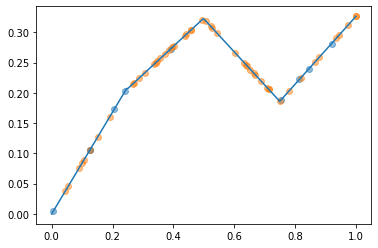

In [79]:
#Generate piecwise linear dataset:
def piece_lin(x,slopes=[]):
    print(slopes)
    xmin = np.min(x)
    xmax = np.max(x)
    n_segs = len(slopes)
    x_segs = np.linspace(xmin,xmax,n_segs+1)
    print(x_segs)
    y_start = 0.0
    y = []
    i_seg = 0
    for xi in x:
        if xi>x_segs[i_seg+1]:
            i_seg+=1
            y_start = y[-1]
        y.append(slopes[i_seg]*(xi-x_segs[i_seg])+y_start)
    return np.array(y)

x = np.linspace(0,1,200)
y = piece_lin(x,2.*np.random.rand(4)-1.)
itrain = np.random.randint(0,200,10)
itest = np.random.randint(0,200,50)
print(itrain)
x_train_raw = x[itrain]
y_train_raw = y[itrain]
x_test_raw = x[itest]
y_test_raw = y[itest]
plt.plot(x,y)
plt.scatter(x_train_raw,y_train_raw,alpha=0.5)
plt.scatter(x_test_raw,y_test_raw,alpha=0.5)

In [80]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

def PolynomialFeatures(x_in,D=2):
    x_out = []
    for i in range(D):
        x_out.append(x_in**(i+1))
    return np.array(x_out).T
        
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim,bias=True)  
        torch.nn.init.uniform_(self.linear.weight,a=-2.,b=2.)

    def forward(self, x):
        out = self.linear(x)
        return out
    
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=16, num_hidden_layers=2):
        super(MLP, self).__init__()
        modules = [nn.Linear(input_dim, hidden_dim,bias=True)]
        for i in range(num_hidden_layers):
            modules.append(nn.Linear(hidden_dim, hidden_dim,bias=True))
        modules.append(nn.Linear(hidden_dim, output_dim,bias=True))
        self.LayerList = nn.ModuleList(modules)  
        #torch.nn.init.uniform_(self.linear.weight,a=-2.,b=2.)

    def forward(self, x):
        for layer in self.LayerList[:-1]:
            x = F.selu(layer(x))
        out = self.LayerList[-1](x)
        return out

In [105]:
def TrainModel(x_train_raw,y_train_raw,N=5,D=2):
    x_train = PolynomialFeatures(x_train_raw,D=D)
    y_train = y_train_raw.reshape(-1, 1)
    input_dim = D
    output_dim = 1

    models = []
    losses = []
    training_set = TensorDataset(torch.Tensor(x_train).requires_grad_(),torch.Tensor(y_train))
    training_loader = torch.utils.data.DataLoader(training_set, batch_size=x_train.shape[0], shuffle=True)
    
    for i_model in range(N):
        torch.manual_seed(i_model)
        model = LinearRegressionModel(input_dim, output_dim)
        #model = MLP(input_dim, output_dim)
        criterion = nn.MSELoss()
        learning_rate = 0.01
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
        #optimizer = torch.optim.LBFGS(model.parameters())
        epochs = 2000
        for epoch in range(epochs):
            #epoch += 1
            # Convert numpy array to torch Variable
            for data in training_loader:
                # Every data instance is an input + label pair
                inputs, labels = data
                #inputs = torch.from_numpy(x_train).requires_grad_()
                #labels = torch.from_numpy(y_train)

                # Clear gradients w.r.t. parameters
                optimizer.zero_grad() 

                # Forward to get output
                outputs = model(inputs.float())

                # Calculate Loss
                loss = criterion(outputs, labels.float())

                # Getting gradients w.r.t. parameters
                loss.backward()

                # Updating parameters
                #optimizer.step(lambda: criterion(model(inputs.float()), labels.float()) )
                optimizer.step()
        #if epoch%100 == 0:
        #    print('epoch {}, loss {}'.format(epoch, loss.item()))
        models.append(model)
        losses.append(loss.item())
        print(i_model,loss.item())
    return models
        
def CheckModels(x_raw,y_raw,models,D=2):
    x = PolynomialFeatures(x_train_raw,D=D)
    #if y_raw.is
    plt.plot(y_raw,y_raw)
    for model in models:
        predicted = model(torch.from_numpy(x).requires_grad_().float()).data.numpy()
        plt.scatter(y_raw,predicted)
    plt.show()
    
def PlotModels(x_raw,x_train_raw,y_train_raw,models,D=2):
    x = PolynomialFeatures(x_raw,D=D)
    plt.scatter(x_train_raw,y_train_raw)
    for model in models:
        predicted = model(torch.from_numpy(x).requires_grad_().float()).data.numpy()
        plt.plot(x_raw,predicted)
    #plt.ylim([-0.2,0.2])
    plt.show()
    

In [103]:
D = 20

models = TrainModel(x_train_raw,y_train_raw,N=5,D=D)

0 0.012747317552566528
1 0.012538244016468525
2 0.012848982587456703
3 0.012854511849582195
4 0.01263374648988247


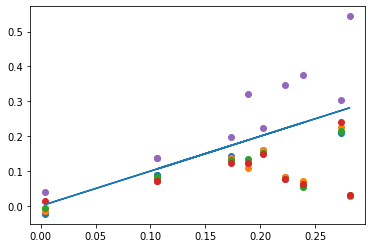

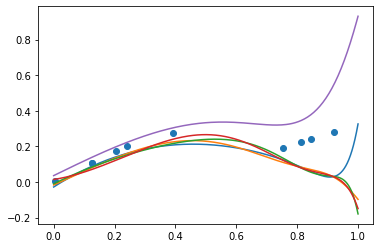

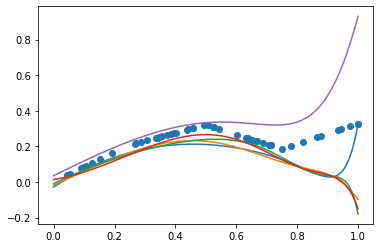

In [104]:
CheckModels(x_train_raw,y_train_raw,models,D=D)
PlotModels(x,x_train_raw,y_train_raw,models,D=D)
PlotModels(x,x_test_raw,y_test_raw,models,D=D)

In [ ]:
x_all = PolynomialFeatures(x,D=D)
predicted = model(torch.from_numpy(x_all).requires_grad_().float()).data.numpy()
print(predicted.shape)

In [ ]:
#plt.plot(x,y)
plt.scatter(x_train_raw,y_train_raw)
plt.scatter(x_test_raw,y_test_raw)
plt.plot(x,predicted)